In [1]:
%load_ext autoreload

In [23]:
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import spacy_transformers
import seaborn as sns
import re
import pickle


In [6]:
df = pd.read_pickle( "/home/samuel/Bureau/text_df_graph.pkl")

In [28]:
test = [ 1.04627452 ,0.60285586 ,-0.4639994 , -0.43288038 , 0.0497877 , -0.8020383 ]

In [29]:
print([1,2,3])

[1, 2, 3]


# Processing raw text

In [33]:
text = pd.read_csv('/home/samuel/Bureau/raw_text.csv')

#graph_path = '/home/samuel/Bureau/df_graph_test_verbatim.pkl'
#df2 = pd.read_pickle(graph_path)

#df = pd.read_hdf('/home/samuel/Bureau/data/etude_1000/clean_13_november_data_v3.h5')

In [52]:
def format_text(line)->str:
    """removes the speaker from the text and replaces it with the [SPEAKER] token, concatenate all content from the text to a single str"""
    text = ''
    for elem in line:
        if elem['speaker'] == 'enqueteur':
            text+=""
        else:
            text+=elem['text']
    return text

def text_to_sentences2(text :str)->list:
    text = text.replace('?','.')
    text = text.replace('!','.')
    text = text.replace('...',' ')
    text = text.replace('..','.')
    text = text.replace('  ',' ')
    text = text.replace('*','')
    return text.split('.')


In [81]:
text = df[df['code'].isin(df2['code'].values)]['part_1_1']
text = text.apply(format_text)

def preprocess_sentences(text:str)->str:
    text = re.sub('[.]{2,4}',"",text)
    text = re.sub("[!?]",".",text)
    text = re.sub('[*]',"",text)
    text = re.sub('[ ]{2,}'," ",text)
    return text

text = text.map(preprocess_sentences)

In [83]:
text.to_csv('/home/samuel/Bureau/raw_text.csv')

# Sentence Segmentation results

In [3]:
def revert_sentence_segmentation(list_sentences):
    for i in range(len(list_sentences)):
        try:
            if list_sentences[i][0] == ' ':
                list_sentences[i] = list_sentences[i][1:]
            list_sentences[i] = list_sentences[i].capitalize()
        except:
            pass
    list_sentences.append(' ')
    ret = '. '.join(list_sentences)
    if ret[-1] != '.':
        ret += '.'
    return ret

In [34]:
def text_to_sentences(text :str)->list:
    text = text.replace('?','.')
    text = text.replace('!','.')
    text = text.replace('...',' ')
    text = text.split('.')
    return [sentence for sentence in text if sentence.count(' ') > 3]

def cut_sentence_by_comma(sentence:str)->list:
    sub_sentence = []
    s = []
    for elem in sentence.replace(',',' , ').split(' '):
        s.append(elem)
        if len(s)> 50 and elem ==',':
            sub_sentence.append(' '.join(s))
            s = []
    return sub_sentence

def text_to_sentences_comma(text:str)->list:
    """Split the text into sentences, then splits again based on commas if the sentence is too long"""
    sentences = text_to_sentences2(text)
    sentences2 = []
    for s in sentences:
        if s.count(' ')> 100:
            #sentence is too long
            #split on commas by the middle so that we have two equal sub-sentences 
            sentences2.extend(cut_sentence_by_comma(s))
        else:
            sentences2.append(s)
    return sentences2

def count_words(list_sentences):
    lengths = []
    for sentence in list_sentences:
        lengths.append(len(sentence.split(' ')))
    return lengths,np.sum(lengths)


## First Method (dot separator)

In [30]:
df_dot_sep= text.apply(text_to_sentences2)

In [31]:
sentences = 0
words = 0
wrd_sent = []
for line in df_dot_sep:
    sentences += len(line)
    sents,wrd = count_words(line)
    wrd_sent.extend(sents)
    words += wrd

In [32]:
sentences

74450

In [33]:
std = np.std(wrd_sent)
print(std)
mean = np.mean(wrd_sent)
print(mean)

24.654632302015813
26.750973807924783


In [219]:
outliers = [x for x in wrd_sent if x > mean + 3 * std]
(len(outliers)/sentences) * 100

1.658831430490262

<Axes: ylabel='Count'>

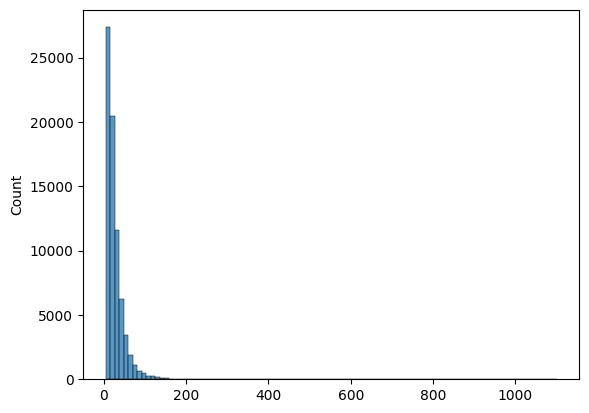

In [34]:
sns.histplot(wrd_sent,bins=100)

## Spacy separator

In [ ]:
try:
    nlp = spacy.load("fr_dep_news_trf")
except:
    !python -m spacy download fr_dep_news_trf
    nlp = spacy.load("fr_dep_news_trf")

In [6]:
nlp = spacy.load('fr_dep_news_trf')

In [7]:
str1 = "c'est la première phrase c'est la deuxième phrase et c'est la troisième phrase mais non en fait c'est la quatrième phrase"

In [1]:
for sent in nlp(str1).sents:
    print(sent.text)

NameError: name 'nlp' is not defined

In [32]:
df_spacy_sep = df_plain_text.apply(lambda x : text_to_sentences_spacy(x,nlp))

In [33]:
sentences = 0
words = 0
wrd_sent = []
for line in df_spacy_sep:
    sentences += len(line)
    sents,wrd = count_words(line)
    wrd_sent.extend(sents)
    words += wrd

In [34]:
words/sentences

22.789698046181172

In [35]:
outliers = len([x for x in wrd_sent if x > 3 * words/sentences]) #must be less than 1%
(outliers/sentences) * 100

3.8993487270574305

<Axes: ylabel='Count'>

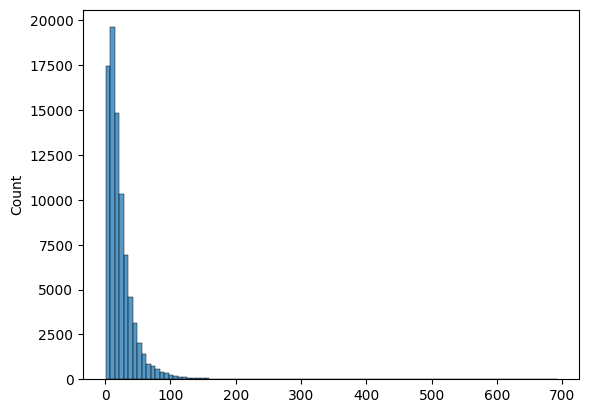

In [36]:
sns.histplot(wrd_sent,bins=100)

## Dot + comma separator

In [35]:
df_comma_dot_sep= text.apply(text_to_sentences_comma)

NameError: name 'text_to_sentences2' is not defined

In [35]:
sentences = 0
words = 0
wrd_sent2 = []
for line in df_comma_dot_sep:
    sentences += len(line)
    sents,wrd = count_words(line)
    wrd_sent2.extend(sents)
    words += wrd

In [25]:
sentences

76410

In [26]:
std = np.std(wrd_sent)
print(std)
mean = np.mean(wrd_sent)
print(mean)

18.53936797706385
26.154338437377305


In [27]:
outliers = [x for x in wrd_sent if x > mean +3 * std]
(len(outliers)/sentences) * 100

1.4513807093312394

<Axes: ylabel='Density'>

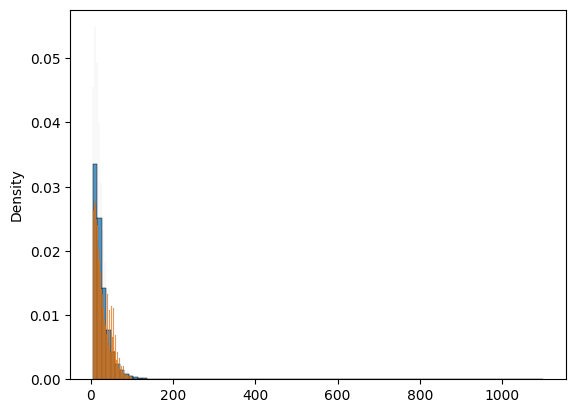

In [43]:
sns.histplot(wrd_sent,bins=100,stat = 'density')
sns.histplot(wrd_sent2,bins=100,stat = 'density')

In [47]:
[x for x in wrd_sent2 if x<5]

[]

<Axes: ylabel='Density'>

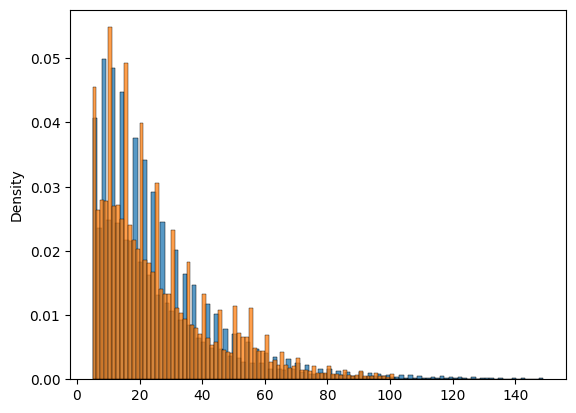

In [46]:
sns.histplot([x for x in wrd_sent if x<150],bins=100,stat = 'density')
sns.histplot(wrd_sent2,bins=100,stat = 'density')

<Axes: ylabel='Density'>

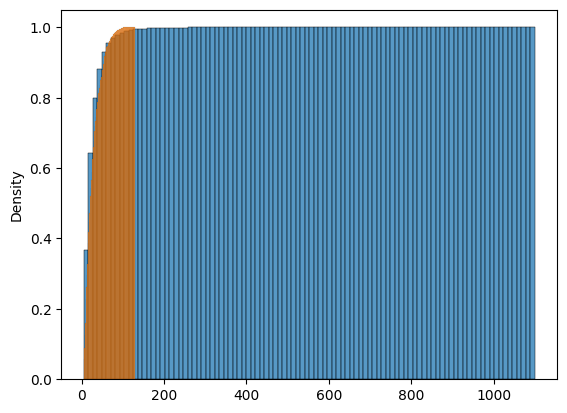

In [42]:
sns.histplot(wrd_sent,bins=100,stat = 'density',cumulative=True)
sns.histplot(wrd_sent2,bins=100,stat = 'density',cumulative=True)

# Other